<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/Finalsims_Cropped_and_grayscale_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import grayscale folder from the google drive


In [4]:
#Get modified images thanks to Jules's preprocessing 
filenames = os.listdir("/content/drive/MyDrive/GrayscaleThresholdBeetleImages")
filenames[:4]


['PaperedControl40v.tif',
 'PaperedControl41v.tif',
 'PaperedControl41v_light.tif',
 'PaperedControl41d.tif']

**Dataset exploration**

In [5]:
#Only include papered or nopapered, throw out pinkpapiermache and light images
train_images=[]
for filename in filenames:
    if 'light' not in filename and (filename.startswith('Papered') or filename.startswith('NoPapered')):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") 


Number of Train images: 757


In [6]:
#Potentially use this filenames for prediction, these are the trapped beetles and we are trying to see if they're marked
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [7]:
#Categories contains a list of two classes - marked and unmarked. This is an array indexed by filenames and each index corresponds to whether the filename corresponds with a marked or an unmarked beetle
categories = []
for filename in train_images:
    if filename.startswith('Papered'):
    #if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [8]:
#creating a dataframe that stores filenames and corresponding categories
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df.head()

,filename,category
0,PaperedControl40v.tif,marked
1,PaperedControl41v.tif,marked
2,PaperedControl41d.tif,marked
3,PaperedControl42v.tif,marked
4,PaperedControl42d.tif,marked


In [9]:
df.groupby('category').size()

category
marked      479
unmarked    278
dtype: int64

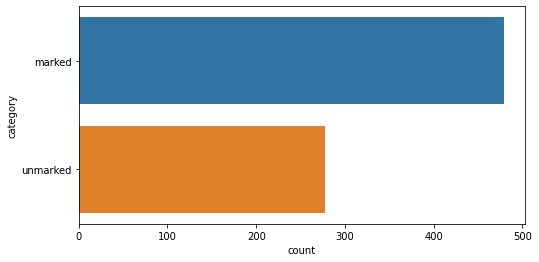

In [10]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [11]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", filenames[0]))
image.shape

(1944, 2592, 3)

**Don't run, just for records**

In [ ]:
#no need to run this cell as the data we have has already been converted to grayscale and cropped, included here for reference used to create the threshcropped images
def threscrop(img):
  #convert to grayscale and apply adaptive thresholding
  grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  blur = cv2.GaussianBlur(grayscale,(5,5),0).astype('uint8')
  retval,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  #return thresh

  #detect edges and crop the image
  canny = cv2.Canny(thresh, 50, 200)
  pts = np.argwhere(canny > 0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)
  #cropped_img = img[y1:y2, x1:x2]
  cropped_img = cv2.resize(thresh[y1:y2, x1:x2], (600,600))
  cropped_img = cropped_img.reshape(cropped_img.shape + (1,))



  return cropped_img

In [ ]:
#this was not used
#no need to run this cell as the data we have has already been converted to grayscale and cropped
def crop(img):#not running this time

  blurred = cv2.blur(img, (3,3))
  canny = cv2.Canny(blurred, 50, 200)

## find the non-zero min-max coords of canny
  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

## crop the region
  cropped = img[y1:y2, x1:x2]
  resized=cv2.resize(cropped, (600,600))
  #cv2.imwrite("cropped.png", cropped)
  return resized

  #tagged = cv2.rectangle(img.copy(), (x1,y1), (x2,y2), (0,255,0), 3, cv2.LINE_AA)
  #cv2.imshow("tagged", tagged)
  #cv2.waitKey()

In [ ]:
#no need to run this cell as the data we have has already been converted to grayscale and cropped
cv2_imshow(threscrop(image))
threscrop(image).shape
#not running this time

In [ ]:
#no need to run this cell as the data we have has already been converted to grayscale and cropped
cv2_imshow(crop(image));
crop(image).shape;
#not running this time

**Visualization**

In [12]:
#function to plot the images of a sample of the beetles
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", image_id))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [13]:
#taking a random sample of our dataframe 
tmp_df = df.sample(9)
tmp_df

,filename,category
205,PaperedTransparent64v.tif,marked
699,PaperedControl12v.tif,marked
50,PaperedControl65d.tif,marked
483,NoPaperedMixed19v.tif,unmarked
582,PaperedMixed18d.tif,marked
462,NoPaperedMixed8d.tif,unmarked
707,PaperedControl16d.tif,marked
227,PaperedTransparent75v.tif,marked
662,PaperedControl3v.tif,marked


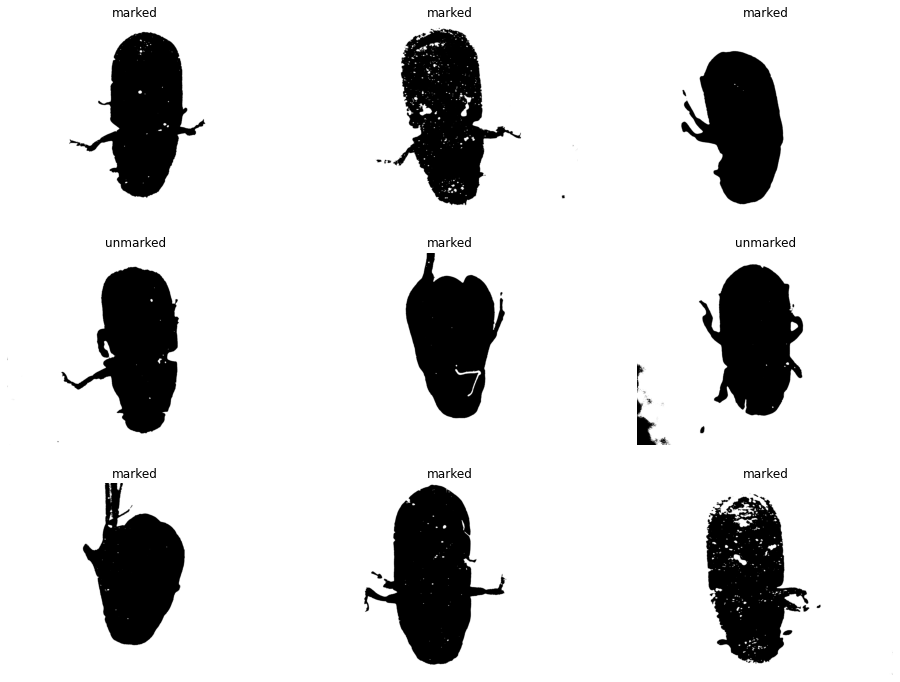

In [14]:
#plotting the images by calling the function with the sample subset as argument 
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [15]:
#Creating training and validation data out of our dataframe with an 80-20 split . This wil be an array of filenames or indices
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

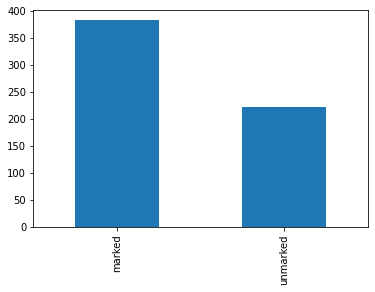

In [16]:
train_df['category'].value_counts().plot.bar()

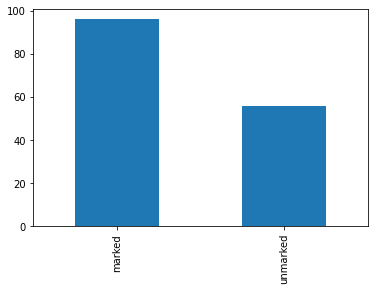

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 32

In [19]:
#Preprocessing the data for the training set with no/default preprocessing function.
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    channel_shift_range = 50.0,
                    brightness_range = [0.3,0.9],
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')


In [20]:
#Default/no preprocessing for the validation set 
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [21]:
#train_set will help with generating valid training sets using the information in datagen_train 
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames belonging to 2 classes.


In [22]:
#validate_set will help with generating valid training sets using the information in datagen_val 
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


In [23]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers

def create_model():
    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    #inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE))

    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 600, 600, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 600, 600, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 601, 601, 3)  0           ['normalization[0][0]'

In [24]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [25]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/finalsim_checkpoint_bestmodel_EB7_cropped.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
  
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('/content/drive/MyDrive/mostrecentmodelfinalsim_EB7_cropped.h5')  
    return history

In [26]:
%%time
results = Model_fit()

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.9767 - accuracy: 0.7487  

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


18/18 [==============================] - 2433s 134s/step - loss: 0.9767 - accuracy: 0.7487 - val_loss: 0.5128 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 2412s 135s/step - loss: 0.7045 - accuracy: 0.8307 - val_loss: 0.6018 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.7882 - accuracy: 0.8133  
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
18/18 [==============================] - 2415s 135s/step - loss: 0.7882 - accuracy: 0.8133 - val_loss: 0.5761 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 2420s 135s/step - loss: 0.6209 - accuracy: 0.8290 - val_loss: 0.5128 - val_accuracy: 0.7266 - lr: 2.0000e-04
Epoch 5/50
18/18 [==============================] - 2390s 134s/step - loss: 0.5113 - accuracy: 0.8586 - val_loss: 0.4776 - val_accuracy: 0.7578 - lr: 2.0000e-04
Epoch 6/50
18/18 [==============================] - 

In [27]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8726003766059875
Val_Cat-Acc:  0.8046875


In [28]:
from keras.models import load_model
resultmodel=load_model("/content/drive/MyDrive/mostrecentmodelfinalsim_EB7_cropped.h5")

In [ ]:
resultmodel.save("/content/drive/MyDrive/model_threscrop_epoch5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_threscrop_epoch5/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


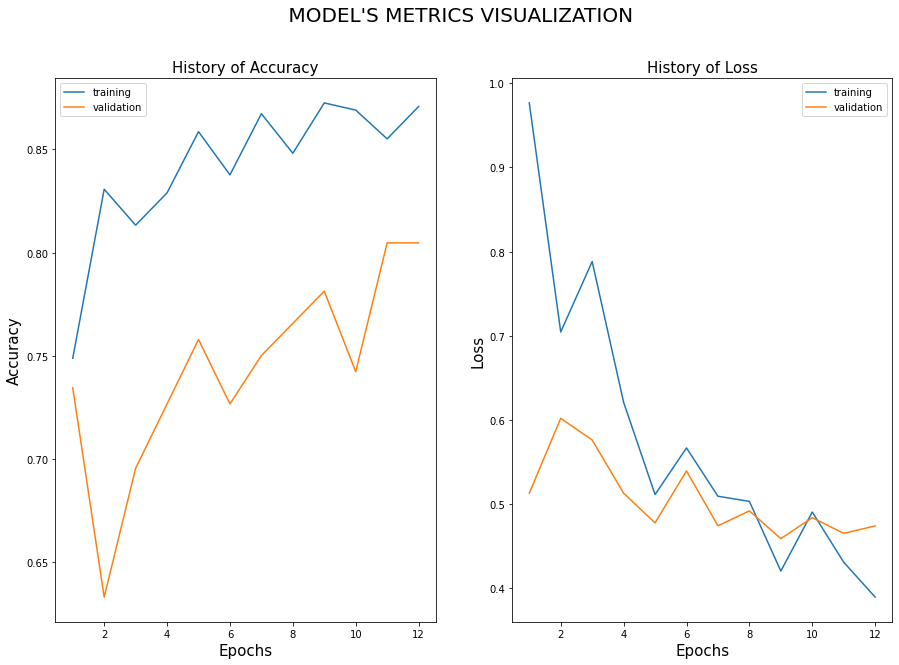

In [29]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

**Testing model's prediction** 

In [30]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
95,PaperedTransparent9v.tif,marked
706,PaperedControl16v.tif,marked
322,NoPaperedGreen35d.tif,unmarked
53,PaperedControl67v.tif,marked
219,PaperedTransparent71v.tif,marked
701,PaperedControl13v.tif,marked
113,PaperedTransparent18v.tif,marked
455,PaperedTransparent108v.tif,marked
189,PaperedTransparent56v.tif,marked
721,PaperedControl23v.tif,marked


In [31]:
nb_samples = tmp_df1.shape[0]

In [32]:

test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator = test_gen.flow_from_dataframe(
    tmp_df1, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)
 #preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
  ##                 width_shift_range = 0.2,
    ##               shear_range = 0.2,
      #              zoom_range = 0.2,
       #             horizontal_flip = True,
        #            vertical_flip = True,
         #           fill_mode = 'nearest')

Found 10 validated image filenames.


In [33]:
predict = resultmodel.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [34]:


tmp_df1['prediction'] = np.argmax(predict, axis=-1)
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1



,filename,category,prediction
95,PaperedTransparent9v.tif,marked,marked
706,PaperedControl16v.tif,marked,marked
322,NoPaperedGreen35d.tif,unmarked,marked
53,PaperedControl67v.tif,marked,marked
219,PaperedTransparent71v.tif,marked,marked
701,PaperedControl13v.tif,marked,marked
113,PaperedTransparent18v.tif,marked,marked
455,PaperedTransparent108v.tif,marked,marked
189,PaperedTransparent56v.tif,marked,marked
721,PaperedControl23v.tif,marked,marked


**Testing on the validation set**

In [35]:
to_samples = validate_df.shape[0]

In [37]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 152 validated image filenames.


In [38]:
predict = resultmodel.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [41]:
validate_df['prediction'] = np.argmax(predict, axis=-1)
validate_df["prediction"] = validate_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,prediction
0,PaperedControl65d.tif,marked,unmarked
1,NoPaperedMixed38v.tif,unmarked,unmarked
2,NoPaperedGreen43v.tif,unmarked,unmarked
3,NoPaperedMixed7v.tif,unmarked,unmarked
4,PaperedTransparent28d.tif,marked,unmarked
...,...,...,...
147,PaperedMixed9v.tif,marked,unmarked
148,NoPaperedGreen61v.tif,unmarked,unmarked
149,NoPaperedGreen57d.tif,unmarked,unmarked
150,PaperedTransparent5d.tif,marked,unmarked


In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

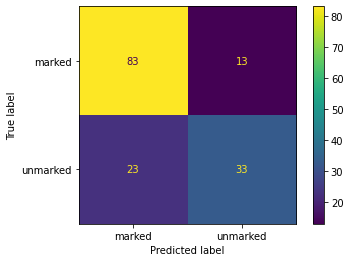

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")


In [44]:
cm

array([[83, 13],
       [23, 33]])

In [45]:
final_metric = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
final_metric

0.7631578947368421

In [46]:
checkpoint_model=load_model("/content/drive/MyDrive/finalsim_checkpoint_bestmodel_EB7_cropped.h5")

In [47]:
checkpoint_predict = checkpoint_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [48]:
validate_df['checkpoint_prediction'] = np.argmax(predict, axis=-1)
validate_df["checkpoint_prediction"] = validate_df["checkpoint_prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,prediction,checkpoint_prediction
0,PaperedControl65d.tif,marked,unmarked,unmarked
1,NoPaperedMixed38v.tif,unmarked,unmarked,unmarked
2,NoPaperedGreen43v.tif,unmarked,unmarked,unmarked
3,NoPaperedMixed7v.tif,unmarked,unmarked,unmarked
4,PaperedTransparent28d.tif,marked,unmarked,unmarked
...,...,...,...,...
147,PaperedMixed9v.tif,marked,unmarked,unmarked
148,NoPaperedGreen61v.tif,unmarked,unmarked,unmarked
149,NoPaperedGreen57d.tif,unmarked,unmarked,unmarked
150,PaperedTransparent5d.tif,marked,unmarked,unmarked


In [49]:
y_true=list(validate_df['category'])
y_pred=list(validate_df['checkpoint_prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

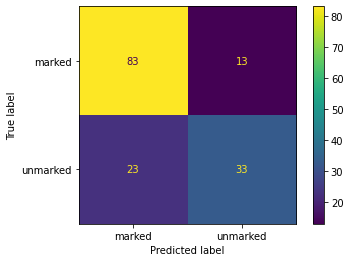

In [50]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")
